In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms as T
from PIL import Image
from ultralytics import YOLO

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

In [3]:
def img_to_tensor(img):
    img = T.ToTensor()(img)
    return img.unsqueeze(0)

def tensor_to_img(img_tensor):
    if img_tensor.shape[0] == 1:
        img_tensor = img_tensor.squeeze(0)
    img = img_tensor.detach().cpu().numpy().swapaxes(0, 1).swapaxes(1, 2)
    img = np.clip(img, 0, 1)
    return Image.fromarray((img * 255).astype(np.uint8))

In [4]:
model = YOLO('models/yolo11x-cls.pt').to(device)
model.eval()
classifier = model.model
model2 = YOLO('models/yolov8x-cls.pt').to(device)
model2.eval()
classifier2 = model2.model
img_ori = Image.open("pig.png").convert("RGB")
transform = T.ToTensor()
img = transform(img_ori).to(device)
img_ori = np.array(img_ori)

img2 = Image.open("pig.png").convert("RGB")
transform = T.Resize(
    size=224,
    interpolation=T.InterpolationMode.BILINEAR,
    max_size=None,
    antialias=True,
)
img2 = transform(img2)
# print(img2)
transform = T.CenterCrop(size=(224, 224))
img2 = transform(img2)
# print(img2)
transform = T.ToTensor()
img2 = transform(img2)
img2 = img2.unsqueeze(dim=0).to(device)
img2.requires_grad = True
# print(img2)
with torch.no_grad():
    logits = classifier(img2)[1]
    print(logits[0][338], logits[0][341])
    print(type(logits))
    print(logits.size())
    orig_prob = torch.softmax(logits, dim=1)
    orig_pred = torch.argmax(orig_prob).item()
    print(f"{orig_pred}: {orig_prob.max().item()}")

with torch.no_grad():
    logits = classifier2(img2)[1]
    print(logits[0][338], logits[0][341])
    print(type(logits))
    print(logits.size())
    orig_prob = torch.softmax(logits, dim=1)
    orig_pred = torch.argmax(orig_prob).item()
    print(f"{orig_pred}: {orig_prob.max().item()}")

tensor(21.2548, device='cuda:0') tensor(3.7360, device='cuda:0')
<class 'torch.Tensor'>
torch.Size([1, 1000])
338: 0.9999620914459229
tensor(26.9332, device='cuda:0') tensor(3.9974, device='cuda:0')
<class 'torch.Tensor'>
torch.Size([1, 1000])
338: 0.9988889098167419


In [5]:
n_iterations = 1000
target_output = torch.tensor([341], dtype=torch.long, device=device)
target_output2 = torch.tensor([719], dtype=torch.long, device=device)
eps = 0.006

x = img.clone()
x.requires_grad = True

optimizer = torch.optim.Adam([x], lr=0.01)
loss_func = torch.nn.CrossEntropyLoss()

def forward(x):
    transform = T.Resize(
        size=224,
        interpolation=T.InterpolationMode.BILINEAR,
        max_size=None,
        antialias=True,
    )
    x = transform(x)
    transform = T.CenterCrop(size=(224, 224))
    x = transform(x)
    x = x.unsqueeze(0)
    x = classifier(x)[1]
    return x

def forward2(x):
    transform = T.Resize(
        size=224,
        interpolation=T.InterpolationMode.BILINEAR,
        max_size=None,
        antialias=True,
    )
    x = transform(x)
    transform = T.CenterCrop(size=(224, 224))
    x = transform(x)
    x = x.unsqueeze(0)
    x = classifier2(x)[1]
    return x

for iteration in range(1, n_iterations + 1):
    optimizer.zero_grad()
    
    logits = forward(x)
    loss = loss_func(logits, target_output)
    loss.backward()

    optimizer.step()

    x.data = torch.clamp(x.data, img - eps, img + eps)

    optimizer.zero_grad()
    
    logits2 = forward2(x)
    loss2 = loss_func(logits2, target_output2)
    loss2.backward()

    optimizer.step()

    x.data = torch.clamp(x.data, img - eps, img + eps)

    if iteration % (n_iterations // 10) == 0:
        current_img = tensor_to_img(x)
        diff = np.abs(np.array(current_img).astype(np.int32) - img_ori.astype(np.int32)).astype(np.uint8)
        min_d, mean_d, max_d = diff.min(), diff.mean(), diff.max()

        with torch.no_grad():
            logits = forward(x)
            logits2 = forward2(x)

        prediction_idx = torch.argmax(logits).item()
        prediction_prob = torch.nn.functional.softmax(logits, dim=1)[0, prediction_idx].item() * 100
        prediction_idx2 = torch.argmax(logits2).item()
        prediction_prob2 = torch.nn.functional.softmax(logits2, dim=1)[0, prediction_idx2].item() * 100

        print(
            f"Iter: {iteration: <4} | Loss1: {loss.item(): .4f} | Pred1: {prediction_idx} ({prediction_prob:.2f}%) | "
            f"Loss2: {loss2.item(): .4f} | Pred2: {prediction_idx2} ({prediction_prob2:.2f}%) | "
            f"min/mean/max diff: {min_d:.2f}/{mean_d:.2f}/{max_d:.2f}"
        )

Iter: 100  | Loss1:  0.0016 | Pred1: 341 (99.84%) | Loss2:  0.0019 | Pred2: 719 (99.82%) | min/mean/max diff: 0.00/0.94/2.00
Iter: 200  | Loss1:  0.0006 | Pred1: 341 (99.94%) | Loss2:  0.0006 | Pred2: 719 (99.94%) | min/mean/max diff: 0.00/0.94/2.00
Iter: 300  | Loss1:  0.0003 | Pred1: 341 (99.97%) | Loss2:  0.0004 | Pred2: 719 (99.96%) | min/mean/max diff: 0.00/0.94/2.00
Iter: 400  | Loss1:  0.0002 | Pred1: 341 (99.98%) | Loss2:  0.0002 | Pred2: 719 (99.98%) | min/mean/max diff: 0.00/0.94/2.00
Iter: 500  | Loss1:  0.0002 | Pred1: 341 (99.98%) | Loss2:  0.0002 | Pred2: 719 (99.98%) | min/mean/max diff: 0.00/0.94/2.00
Iter: 600  | Loss1:  0.0001 | Pred1: 341 (99.99%) | Loss2:  0.0001 | Pred2: 719 (99.99%) | min/mean/max diff: 0.00/0.94/2.00
Iter: 700  | Loss1:  0.0001 | Pred1: 341 (99.99%) | Loss2:  0.0001 | Pred2: 719 (99.99%) | min/mean/max diff: 0.00/0.94/2.00
Iter: 800  | Loss1:  0.0001 | Pred1: 341 (99.99%) | Loss2:  0.0001 | Pred2: 719 (99.99%) | min/mean/max diff: 0.00/0.95/2.00


2


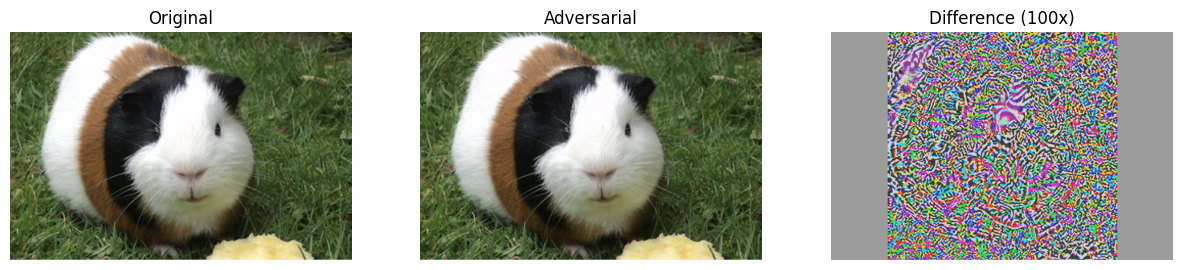

In [6]:
delta_img = np.abs(np.array(tensor_to_img(x)).astype(np.int32) - img_ori.astype(np.int32)).astype(np.uint8)
print(np.max(delta_img))

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
titles = ["Original", "Adversarial", "Difference (100x)"]
imgs = [img_ori, np.array(tensor_to_img(x)), ~delta_img * 100]
for i in range(3):
    ax[i].imshow(imgs[i])
    ax[i].set_title(titles[i])
    ax[i].axis("off")

plt.show()

img_adv = tensor_to_img(x)
img_adv.save("pig_ad.png")